In [31]:
import torch
import torch.onnx as onnx
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import torchvision


In [32]:
training_data = torchvision.datasets.MNIST(
    '/files/',
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                              torchvision.transforms.Normalize((0.1307,), (0.3081,))]
                                             )
)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
        transforms.ToTensor(),
    ])),
    batch_size=1, shuffle=True)

In [33]:
train_dataloader = DataLoader(training_data, 64, shuffle=True)
epochs = 3
learning_rate = 0.01
momentum = 0.5
log_interval = 10
batch_size = 64

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [34]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [35]:
model = Net()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [36]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
conv1.weight 	 torch.Size([10, 1, 5, 5])
conv1.bias 	 torch.Size([10])
conv2.weight 	 torch.Size([20, 10, 5, 5])
conv2.bias 	 torch.Size([20])
fc1.weight 	 torch.Size([50, 320])
fc1.bias 	 torch.Size([50])
fc2.weight 	 torch.Size([10, 50])
fc2.bias 	 torch.Size([10])
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'params': [0, 1, 2, 3, 4, 5, 6, 7]}]


In [37]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (data, target) in enumerate(train_dataloader):
        # Compute prediction and loss
        pred = model(data)
        loss = loss_fn(pred, target)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(data)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [38]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [39]:
def advTrain(torch_model, train_loader, test_loader,
        nb_epochs=epochs, batch_size=batch_size, learning_rate=learning_rate):
    optimizer = optim.Adam(torch_model.parameters(), lr=learning_rate)
    train_loss = []
    total = 0
    correct = 0
    totalAdv = 0
    correctAdv = 0
    step = 0
    # breakstep = 0
    for _epoch in range(nb_epochs):
      for xs, ys in train_loader:
        xs.requires_grad = True
        #Normal Training
        if torch.cuda.is_available():
          xs, ys = xs.cuda(), ys.cuda()
        optimizer.zero_grad()
        preds = torch_model(xs)
        loss = F.nll_loss(preds, ys)
        loss.backward()  # calc gradients
        train_loss.append(loss.data.item())
        optimizer.step()  # update gradients
        preds_np = preds.cpu().detach().numpy()
        correct += (np.argmax(preds_np, axis=1) == ys.cpu().detach().numpy()).sum()
        total += train_loader.batch_size

        #Adversarial Training
        xs = fgsm_attack(xs, 0.3, xs.grad.data)
        if torch.cuda.is_available():
            xs, ys = xs.cuda(), ys.cuda()
        optimizer.zero_grad()
        preds = torch_model(xs)
        loss = F.nll_loss(preds, ys)
        loss.backward()  # calc gradients
        train_loss.append(loss.data.item())
        optimizer.step()  # update gradients
        preds_np = preds.cpu().detach().numpy()
        correctAdv += (np.argmax(preds_np, axis=1) == ys.cpu().detach().numpy()).sum()
        totalAdv += train_loader.batch_size
        
        step += 1
        if total % 1000 == 0:
          acc = float(correct) / total
          print('[%s] Clean Training accuracy: %.2f%%' % (step, acc * 100))
          total = 0
          correct = 0
          accAdv = float(correctAdv) / totalAdv
          print('[%s] Adv Training accuracy: %.2f%%' % (step, accAdv * 100))
          totalAdv = 0
          correctAdv = 0


In [40]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (data, target) in enumerate(train_dataloader):
        # Compute prediction and loss
        pred = model(data)
        loss = loss_fn(pred, target)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(data)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [42]:
epochs = 6
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    #advTrain(model, train_dataloader, test_loader, epochs, batch_size, learning_rate)
    train_loop(train_dataloader, model, loss_fn, optimizer)
print("Done!")

Epoch 1
-------------------------------
loss: 0.445364  [    0/60000]
loss: 0.451837  [ 6400/60000]
loss: 0.368117  [12800/60000]
loss: 0.249163  [19200/60000]
loss: 0.427414  [25600/60000]
loss: 0.381666  [32000/60000]
loss: 0.351397  [38400/60000]
loss: 0.469002  [44800/60000]
loss: 0.255920  [51200/60000]
loss: 0.222554  [57600/60000]
Epoch 2
-------------------------------
loss: 0.189543  [    0/60000]
loss: 0.460772  [ 6400/60000]
loss: 0.146829  [12800/60000]
loss: 0.335408  [19200/60000]
loss: 0.375523  [25600/60000]
loss: 0.442604  [32000/60000]
loss: 0.288641  [38400/60000]
loss: 0.398377  [44800/60000]
loss: 0.252349  [51200/60000]
loss: 0.277234  [57600/60000]
Epoch 3
-------------------------------
loss: 0.267556  [    0/60000]
loss: 0.194974  [ 6400/60000]
loss: 0.339353  [12800/60000]
loss: 0.232323  [19200/60000]
loss: 0.221278  [25600/60000]
loss: 0.303303  [32000/60000]
loss: 0.207864  [38400/60000]
loss: 0.126219  [44800/60000]
loss: 0.355769  [51200/60000]
loss: 0.19

Load:

the_model = TheModelClass(*args, **kwargs)
the_model.load_state_dict(torch.load(PATH))

In [43]:
def test(model, device, test_loader, epsilon):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        # get the index of the max log-probability
        init_pred = output.max(1, keepdim=True)[1]

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        # get the index of the max log-probability
        final_pred = output.max(1, keepdim=True)[1]
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 50):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append(
                    (init_pred.item(), final_pred.item(), adv_ex))
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append(
                    (init_pred.item(), final_pred.item(), adv_ex))

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon,
          correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [44]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
use_cuda = True
print("CUDA Available: ", torch.cuda.is_available())
device = torch.device("cuda" if (
    use_cuda and torch.cuda.is_available()) else "cpu")

CUDA Available:  False


Epsilon: 0	Test Accuracy = 8875 / 10000 = 0.8875
Epsilon: 0.05	Test Accuracy = 8459 / 10000 = 0.8459
Epsilon: 0.1	Test Accuracy = 7636 / 10000 = 0.7636
Epsilon: 0.15	Test Accuracy = 6279 / 10000 = 0.6279
Epsilon: 0.2	Test Accuracy = 4488 / 10000 = 0.4488
Epsilon: 0.25	Test Accuracy = 2877 / 10000 = 0.2877
Epsilon: 0.3	Test Accuracy = 1723 / 10000 = 0.1723


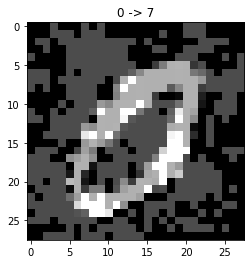

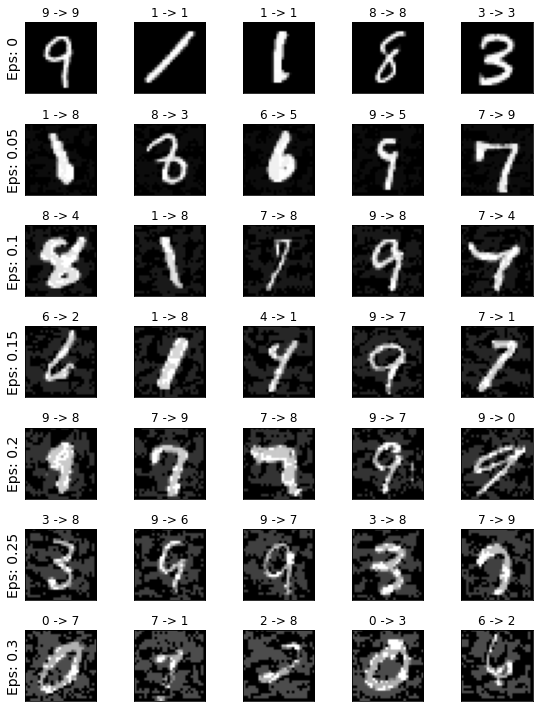

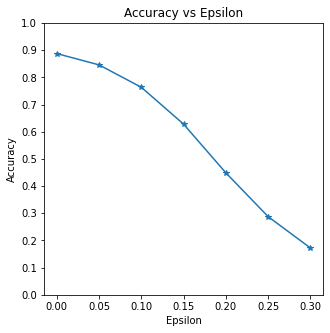

In [45]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

# epsilon = 0.3
# acc, ex = test(model, device, test_loader, eps)
# accuracies.append(acc)

a, b, c, d, e, f, g = examples


# %%
# a = 0.0, b = 0.05, c = 0.1, d = 0.15, e = 0.2, f = 0.25, g = 0.3
label, new_label, image, = g[0]
plt.title("{} -> {}".format(label, new_label))
plt.imshow(image, cmap="gray")

# %%
cnt = 0
plt.figure(figsize=(8, 10))
for i in range(len(epsilons)):
    for j in range(5):
        cnt += 1
        plt.subplot(len(epsilons), 5, cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        currArr = examples[i]
        orig, adv, ex = currArr[j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

# %%
plt.figure(figsize=(5, 5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()